<a href="https://colab.research.google.com/github/VrindaBajaj20/ai-attack-snow3g-nea1/blob/main/experiments/nea1_vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Layer, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
print("Please upload the CSV file.")
uploaded = files.upload()

file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name)

required_columns = ["COUNT", "Direction", "Bearer ID", "LENGTH", "KEY"]
if not all(col in df.columns for col in required_columns):
    raise ValueError(f"Missing required columns: {', '.join(required_columns)}")

Please upload the CSV file.


Saving snow3g_keystream (1).csv to snow3g_keystream (1).csv


In [3]:
# Validate required columns
required_columns = ["KEY", "Direction", "LENGTH", "COUNT", "Bearer ID", "Keystream"]
if not all(col in df.columns for col in required_columns):
    raise ValueError(f"Missing required columns: {', '.join(required_columns)}")

In [4]:
# Convert binary string to numpy array of bits
def binstr_to_bits(bin_str):
    return np.array([int(b) for b in bin_str])

df['Keystream_bits'] = df['Keystream'].apply(binstr_to_bits)
df['Key_bits'] = df['KEY'].apply(lambda k: np.array([int(b) for b in bin(int(k,16))[2:].zfill(128)]))

# Stack into ML-ready arrays
X = np.stack(df['Keystream_bits'].values).astype(np.float32)
y = np.stack(df['Key_bits'].values).astype(np.int32)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Preprocessing done. Shapes:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

Preprocessing done. Shapes:
X_train: (80, 128) y_train: (80, 128)
X_test: (20, 128) y_test: (20, 128)


In [7]:
# === Step 3: Define Sampling and KL Loss ===
latent_dim = 32
input_dim = 128

def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=tf.shape(z_mean))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class KLLossLayer(Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        self.add_loss(K.mean(kl_loss))
        return inputs


In [16]:
# Encoder
inputs = Input(shape=(input_dim,))
h = Dense(64, activation='relu')(inputs)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)
z = Lambda(sampling)([z_mean, z_log_var])
KLLossLayer()([z_mean, z_log_var])  # adds KL loss

# Decoder
decoder_h = Dense(64, activation='relu')
decoder_out = Dense(input_dim, activation='sigmoid')
outputs = decoder_out(decoder_h(z))

In [17]:
# VAE model
vae = Model(inputs, outputs)
vae.compile(optimizer='adam', loss='binary_crossentropy')
vae.fit(X_train, X_train, epochs=30, batch_size=128, validation_data=(X_test, X_test))

Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.7480 - val_loss: 0.7298
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.7368 - val_loss: 0.7257
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.7307 - val_loss: 0.7205
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.7263 - val_loss: 0.7214
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.7215 - val_loss: 0.7170
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.7194 - val_loss: 0.7155
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.7163 - val_loss: 0.7166
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.7116 - val_loss: 0.7058
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.7070 - val_loss: 0.7122
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.7121 - val_loss: 0.7179
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.7084 - val_loss: 0.7072
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.7059 - val_loss: 0.7042
Ep

In [18]:
# Latent vectors
encoder = Model(inputs, z)
z_train = encoder.predict(X_train)
z_test = encoder.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


In [19]:
# === CNN on Latent Features ===
z_train_cnn = z_train.reshape(-1, latent_dim, 1)
z_test_cnn = z_test.reshape(-1, latent_dim, 1)

cnn_model = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(latent_dim, 1)),
    MaxPooling1D(2),
    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(2),
    Flatten(),
    Dense(128, activation='sigmoid')  # 128-bit output
])
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.fit(z_train_cnn, y_train, epochs=30, batch_size=128, validation_data=(z_test_cnn, y_test))


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0000e+00 - loss: 0.6986 - val_accuracy: 0.0000e+00 - val_loss: 0.6986
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.0000e+00 - loss: 0.6948 - val_accuracy: 0.0000e+00 - val_loss: 0.6976
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.0000e+00 - loss: 0.6916 - val_accuracy: 0.0000e+00 - val_loss: 0.6972
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.0000e+00 - loss: 0.6891 - val_accuracy: 0.0000e+00 - val_loss: 0.6973
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.0000e+00 - loss: 0.6869 - val_accuracy: 0.0000e+00 - val_loss: 0.6977
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.0000e+00 - loss: 0.6850 - val_accuracy: 0.0000e+00 - val_loss: 0.6983
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.0000e+00 - loss: 0.6833 - val_accuracy: 0.0000e+00 - val_loss: 0.6991
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.00

In [20]:

# === XGBoost on Latent Features ===
xgb_latent = MultiOutputClassifier(XGBClassifier(n_estimators=200, n_jobs=-1, verbosity=0))
xgb_latent.fit(z_train, y_train)
y_pred_latent = xgb_latent.predict(z_test)

In [21]:
# === VAE Reconstruction ===
y_pred_vae = (vae.predict(X_test) > 0.5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


In [22]:
# === Bitwise Accuracy ===
bitwise_acc_vae = np.mean(y_pred_vae == y_test, axis=0)
bitwise_acc_cnn = np.mean((cnn_model.predict(z_test_cnn) > 0.5).astype(int) == y_test, axis=0)
bitwise_acc_latent = np.mean(y_pred_latent == y_test, axis=0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


In [23]:
# Fusion (VAE + XGBoost latent)
y_fused = ((y_pred_vae + y_pred_latent)/2) > 0.5
bitwise_acc_fused = np.mean(y_fused == y_test, axis=0)

In [24]:
# === PRINT RESULTS ===
print(f"VAE Bitwise Accuracy per bit:\n{bitwise_acc_vae}")
print(f"CNN on Latent Bitwise Accuracy per bit:\n{bitwise_acc_cnn}")
print(f"XGBoost Latent Bitwise Accuracy per bit:\n{bitwise_acc_latent}")
print(f"VAE + XGBoost Fusion Bitwise Accuracy per bit:\n{bitwise_acc_fused}")

VAE Bitwise Accuracy per bit:
[0.5  0.3  0.55 0.4  0.4  0.5  0.3  0.55 0.45 0.7  0.65 0.5  0.55 0.65
 0.55 0.6  0.25 0.55 0.65 0.5  0.6  0.6  0.45 0.45 0.4  0.55 0.45 0.45
 0.6  0.55 0.4  0.6  0.45 0.3  0.5  0.55 0.55 0.65 0.35 0.25 0.5  0.6
 0.45 0.45 0.45 0.4  0.35 0.6  0.55 0.4  0.55 0.45 0.4  0.5  0.4  0.7
 0.5  0.5  0.4  0.7  0.35 0.45 0.5  0.3  0.45 0.45 0.55 0.6  0.4  0.25
 0.4  0.65 0.6  0.55 0.7  0.5  0.45 0.4  0.75 0.55 0.45 0.6  0.6  0.65
 0.35 0.4  0.5  0.45 0.6  0.45 0.5  0.65 0.5  0.35 0.45 0.65 0.4  0.4
 0.45 0.65 0.3  0.3  0.5  0.35 0.45 0.5  0.5  0.55 0.55 0.5  0.65 0.45
 0.6  0.4  0.3  0.5  0.35 0.5  0.65 0.5  0.5  0.45 0.8  0.5  0.55 0.45
 0.55 0.6 ]
CNN on Latent Bitwise Accuracy per bit:
[0.45 0.45 0.45 0.45 0.45 0.4  0.55 0.45 0.5  0.45 0.6  0.65 0.55 0.45
 0.6  0.35 0.6  0.5  0.65 0.55 0.35 0.6  0.4  0.3  0.35 0.5  0.6  0.4
 0.65 0.6  0.5  0.55 0.5  0.65 0.55 0.55 0.45 0.45 0.45 0.6  0.6  0.6
 0.4  0.55 0.4  0.55 0.5  0.55 0.4  0.5  0.5  0.5  0.4  0.6  0.4  0.4
 

In [26]:
# === OVERALL ACCURACY ===
overall_acc_vae = np.mean(y_pred_vae == y_test)
overall_acc_cnn = np.mean((cnn_model.predict(z_test_cnn) > 0.5).astype(int) == y_test)
overall_acc_latent = np.mean(y_pred_latent == y_test)
overall_acc_fused = np.mean(y_fused == y_test)

print(f"Overall VAE Accuracy: {overall_acc_vae * 100:.2f}%")
print(f"Overall CNN on Latent Accuracy: {overall_acc_cnn * 100:.2f}%")
print(f"Overall XGBoost Latent Accuracy: {overall_acc_latent * 100:.2f}%")
print(f"Overall VAE + XGBoost Fusion Accuracy: {overall_acc_fused * 100:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Overall VAE Accuracy: 49.49%
Overall CNN on Latent Accuracy: 50.12%
Overall XGBoost Latent Accuracy: 49.49%
Overall VAE + XGBoost Fusion Accuracy: 49.26%


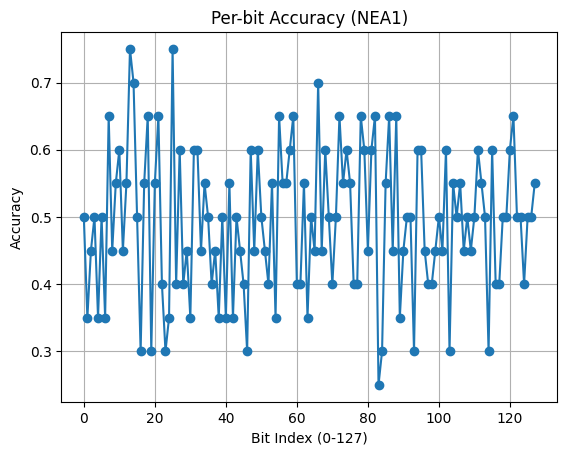

In [25]:
# === PLOT BITWISE ACCURACY ===
plt.plot(bitwise_acc_fused, marker='o')
plt.title("Per-bit Accuracy (NEA1)")
plt.xlabel("Bit Index (0-127)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()